# Lesson 11: Corner Detection

![corner detection](../images/corner.png)

Corner is the intersection of two edges. **Application of corner:** Panorama stitching, image detection, object tracking, 3D construction, object matching.

Algorithm to detect corner (<a href="#moravec">Moravec</a>):
* Make a patch center
* Make a window
* Shift the window in every possible direction centered
* Note all difference of the original patch
* If all the direction contains a lot of difference, there doesn't exist a single direction that has small difference, then it a *Corner*.
![corner](../images/corn.png)

## SSD - Sum of square difference

![ssd](../images/ssd2.png) ![ssd](../images/ssd.png)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

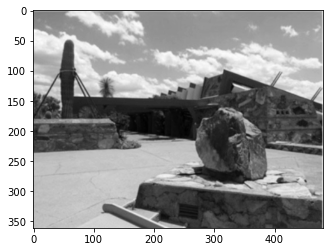

In [2]:
im = cv2.imread("../images/im3.PNG")
img = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap="gray")

In [3]:
numRols, numCols = img.shape[0], img.shape[1]

In [4]:
directions = {
    'left':(0,-1),
    'right':(0,1),
    'up':(-1,0),
    'down':(1,0),
    'upLeft':(-1,-1),
    'upRight':(-1,1),
    'downLeft':(1,-1),
    'downRight':(1,1)
}

In [5]:
C = np.zeros(img.shape)
for i in range(2,numRols-2):
    for j in range(2,numCols-2):
        minSSD = -1
        for d in directions.values():
            u , v = d[0],d[1]
            P1 = img[i-1:i+2, j-1:j+2]
            P2 = img[i+u-1:i+u+2,j+v-1:j+v+2]
            ssd = np.sum((P1-P2)**2)
            if minSSD == -1:
                minSSD = ssd
            elif ssd < minSSD:
                minSSD = ssd
        C[i,j] = minSSD

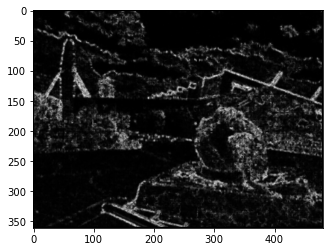

In [6]:
plt.imshow(C,cmap='gray');

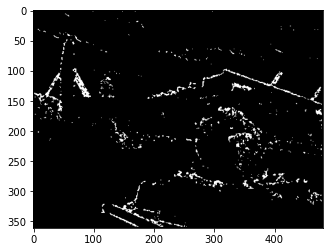

In [7]:
th = C.mean() + 3*C.std()
C_im = C > th
plt.imshow(C_im, cmap='gray')

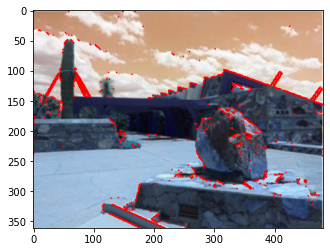

In [13]:
img2 = im[:,:,::-1]
idx = np.argwhere(C_im)
r,c = idx[:,0], idx[:,1]
for i in range(len(r)):
    img2 = cv2.circle(np.float32(img2),(c[i],r[i]),radius=1, color=(0,0,255), thickness=-1)
plt.imshow(np.array(img2[:,:,::-1], np.uint8))

### Moravec
<div id="moravec"></div>

* For each pixel, build a patch around it
* Compare this patch with the neighboring patches
* If it is dissimiliar from the patches, then the pixel is a *Corner*

## Harris Corner Detector

* Check all the directions. i.e all continous direction.
* Compute `SDD` that is minimum
* If minSSD is large, it is the *Corner*.

${\large SSD_{xy} (u,v)} = \sum\limits_{i=-1}^1 \sum\limits_{j=-1}^1 (I(x+u+i, y+v+j) - I(x+i, y+j))^2 \\ r = x+u+i, c = y+u+j \\[5mm] I(x+u+i,y+v+j) \approx I_x(x+i,y+j)u + I_y(x+i,y+j)v + I(x+i,y+j) \\[5mm] {\large SSD_{xy} (u,v)} = \sum\limits_{i=-1}^1 \sum\limits_{j=-1}^1 (uI_x(x++i, y+j) + vI_y(x+i, y+j))^2 $ 

* let a rep u, b rep $I_x(x+1, y+j)$, c rep v, d rep $I_y(x+1, y+j).$ 

**Recall that:**

$(ab + cd)^2 = \left( \begin{bmatrix} a & c \end{bmatrix}\begin{bmatrix} b \\ d \end{bmatrix} \right) \left(\begin{bmatrix} b & d \end{bmatrix}\begin{bmatrix} a \\ c \end{bmatrix} \right)$

**Hence**:

$\sum \sum \begin{bmatrix} u & v \end{bmatrix}\begin{bmatrix} I_x \\ I_y \end{bmatrix} \begin{bmatrix} I_x & I_y \end{bmatrix}\begin{bmatrix} u \\ v \end{bmatrix} \\ \begin{bmatrix} u & v \end{bmatrix} \sum \sum \left( \begin{bmatrix} I_x \\ I_y \end{bmatrix} \begin{bmatrix} I_x & I_y \end{bmatrix}\begin{bmatrix} u \\ v \end{bmatrix} \right )$

$\begin{bmatrix} u & v \end{bmatrix} \left(\sum \sum \begin{bmatrix} I_x^2 &  I_xI_y \\ I_xI_y & I_y^2 \end{bmatrix} \right) \begin{bmatrix} u \\ v \end{bmatrix} \\[7mm] SSD_{xy} (u,v) = \begin{bmatrix} u & v \end{bmatrix} \left( \sum\limits_{i=-1}^1 \sum\limits_{j=-1}^1 \begin{bmatrix} I_x^2(x+i, y+j) & I_x(x+i,y+j)I_y(x+i,y+j) \\ I_x(x+i, y+j)I_y(x+i,y+j) & I_y^2(x+i,y+j)\end{bmatrix} \right)\begin{bmatrix} u \\ v \end{bmatrix}$

${\large SSD_{xy} (u,v)} = {\large d^T S d} \\[7mm] {\large SSD_{xy} (d)} = {\large min(d^T S d)}$

In [9]:
img

array([[248, 245, 245, ..., 247, 248, 252],
       [223, 206, 206, ..., 217, 223, 244],
       [182, 143, 143, ..., 170, 183, 232],
       ...,
       [208, 188, 191, ...,  73,  98, 206],
       [209, 189, 193, ...,  71,  96, 206],
       [210, 191, 194, ...,  70,  96, 206]], dtype=uint8)

In [10]:
I = np.float64(img)
mask_x = np.array([[-1],[1]])
Ix = cv2.filter2D(I,-1,mask_x)
Iy = cv2.filter2D(I,-1,mask_x.T)
Ix2, Iy2, IxIy = Ix*Ix, Iy*Iy, Ix*Iy
K = np.ones((3,3))
sIx2 = cv2.filter2D(Ix2,-1,K)
sIy2 = cv2.filter2D(Iy2,-1,K)
sIxIy = cv2.filter2D(IxIy,-1,K)

In [11]:
# Larger & SmallerEigenvalue
L1 = ((sIx2+sIy2)+((sIx2+sIy2)**2 - 4*(IxIy**2))**0.5)/2
L2 = ((sIx2+sIy2)-((sIx2+sIy2)**2 - 4*(IxIy**2))**0.5)/2

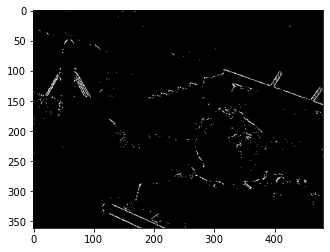

In [12]:
th = L2.mean()+3*L2.std()
C_im = L2 > th
plt.imshow(C_im, cmap='gray')

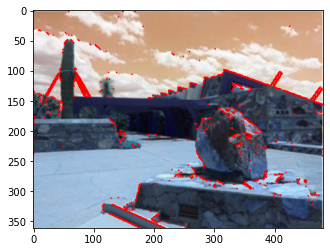

In [15]:
img2 = im[:,:,::-1]
idx = np.argwhere(C_im)
r,c = idx[:,0], idx[:,1]
for i in range(len(r)):
    img2 = cv2.circle(np.float32(img2),(c[i],r[i]),radius=1, color=(0,0,255), thickness=-1)
plt.imshow(np.array(img2[:,:,::-1], np.uint8))

**Structure Tensor**

$S =\begin{bmatrix} a & b \\ c & d \end{bmatrix} \\ \lambda_1 = max \to maxSSD\\ \lambda_2 = min \to minSSD$

**Hence if:**

$\lambda_2 \approx 0 and \lambda_1 \approx high, It \hspace{1mm} is\hspace{1mm} Edge. \\ \lambda_2 \approx 0 and \lambda_1 \approx 0, It\hspace{1mm} is\hspace{1mm} Flat \\ \lambda_2 \approx large, It \hspace{1mm}is \hspace{1mm}Corner.$